# CubeSat Image Recognition Pytorch Model
In this Jupyter Notebook a pytorch model to recognise a cubic satellite, also known as CubeSat, is developed and trained using the pytorch library. The problem is taken on by training two separate neural networks: one for the (pixel dimensions-normalised) x and y coordinates, and a second one for the z coordinate, which is not normalizable by the dimensions of the image. This choice was due to normalization reasons, but a future project will be dedicated to training a single neural network that predicts all three outputs. Optimal results are expected as the current version requires twice the training time (as there are two neworks). Some remarks:

- The images were taken from the dataset https://www.kaggle.com/datasets/eberhardtkorf/synthetic-cubesat which contains synthetic CubeSat images made using Unreal Engine.

- The true position in the labels is in unknown units. Nevertheless a projection onto the camera pixel is done by creating a camera matrix and projecting using the opencv library

- The main source of imprecision in the model comes from the z prediction. This is why the error in the pixel projection is extremely low, whereas in the z coordinate it is larger and ends up propagating when making the inverse projection back to the true position. This is exemplified at the end of the notebook, where a few examples and some numbers are shown, plus the evolution of the losses with epochs and with number of examples seen. The loss of the z coordinate regressor network is always larger.

In any case the results are very good, reaching (x,y) pixel prediction errors of order 1-2% and z predictions of ~ 10-12% in 50 epochs of training. Future work will delve on improving on these results and creating a single network that predicts all three outputs.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.amp import GradScaler, autocast

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from PIL import Image
import cv2
import time

torch.manual_seed(42)
np.random.seed(42)

In [2]:
# Device to use (cpu, gpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device_str = "cuda" if torch.cuda.is_available() else "cpu"

!python --version
print(device)
print(device_str)

Python 3.10.12
cpu
cpu


# Camera Data and Handling

In [3]:
# Since this project deals with coordinates with respect to a camera, we need a conversion from pixels to real-world coordinates and vice-versa
f = 12                   # Focal length in mm
image_width = 2448/8       # Image width (resolution)
image_height = 2048/8      # Image height (resolution)
sensor_height = 8.4456   # Sensor height in mm
sensor_width = 7.0656    # Sensor width in mm
cx = image_width / 2     # Focal centre (at the origin)
cy = image_height / 2

fx = f * image_width / sensor_width
fy = f * image_height / sensor_height

# Camera matrix

K = np.array([[fx, 0, cx],
             [0, fy, cy],
             [0, 0, 1]], dtype = float)

In [4]:
def position_to_pixel(position, K, norm = False):
    '''
    Function to project a 3D point to a pixel
        - position (np.array vector or matrix of vectors): 3D coordinates to be projected to pixel
        - K (np.array matrix): Camera matrix
        - norm (bool): Establishes whether the output is normalised by the dimensions of the image in pixels
    '''
    # cv2.projectPoints expects an array of shape (N,3) even if N=1
    position = np.array(position, dtype=np.float32).reshape(-1, 3)
    pixels, _ = cv2.projectPoints(position, np.zeros((3, 1), dtype=np.float32), np.zeros((3, 1), dtype=np.float32), K, distCoeffs=None)
    # If norm=True we normalise by the dimensions of the image
    if norm:
        pixels[:,0][:,0]/=2448/8
        pixels[:,0][:,1]/=2048/8
        
    return pixels[:,0]


def pixel_to_position(pixel, z, K, norm = False):
    '''
    Function to project a pixel to (x,y) coordinates. Z is required to be known
        - pixel (tuple (int, int)): 2D pixel position
        - z (float): Distance perpendicular to the camera
        - K (np.array matrix): Camera matrix
        - norm (bool): Establishes whether the input is normalised by the dimensions of the image in pixels
    '''
    if norm:
        x = (pixel[0]*2448/8 - K[0,2]) * z / K[0,0]
        y = (pixel[1]*2048/8 - K[1,2]) * z / K[1,1]
        
    else:
        x = (pixel[0] - K[0,2]) * z / K[0,0]
        y = (pixel[1] - K[1,2]) * z / K[1,1]

    return np.array([x,y,z])
    

# Definition of the Dataset Object (on-demand data loading)

In [5]:
# First we initialize the dataset object
# We want the network to predict the (x,y) position of the satellite in pixels
class CubeSat_Dataset(Dataset):

    def __init__(self, image_dir, label_file, mode = 'train', validation_split = (-1,-1), transform = None, num_labels = 3):
        '''
        Initialises the dataset object with the inputs:
            - image_file (str): path to file with images
            - label_file (str): path to file with labels
            - mode (str) indicates whether this loads the training or validation dataset
            - validation_split (tuple (float, int))
                validation_split[0] specifies the percentage of the data to be used for validation
                validation_split[1] specifies the random seed (needed for reproducibility to split two different  objects in the same way)
            if any of the two numbers are negative no split will be done
            - transform: transformation to apply to the data
        '''
        # Since for this project the loading of the data into memory is too demanding, the data is lazy loaded, i.e. the specific element is loaded on demand
        self.image_files = sorted([os.path.join(image_dir,f) for f in os.listdir(image_dir) if f.endswith('.jpg')])[:]
        
        # If the number of labels is 2, the dataset will return the normalised position in pixels
        if num_labels == 2:
            self.labels = pd.read_csv(label_file).iloc[:, 1:(num_labels + 2)].values
            self.labels = position_to_pixel(self.labels, K, norm=True)
            print("Creating dataset with 2D normalised pixel positions")
            
        elif num_labels == 'z':
            self.labels = pd.read_csv(label_file).iloc[:, 3].values.reshape(-1, 1)
            
        else:
            self.labels = pd.read_csv(label_file).iloc[:, 1:(num_labels + 1)].values
            print(f"Creating dataset with {num_labels}D labels directly from csv file")

        # We want to split the dataset to also get evaluation data
        if validation_split[0]>0 and validation_split[1]>0:
            # Note, i specify the random state in validation_split[1] for  reproducibility
            train_image_files, val_image_files, train_labels, val_labels = train_test_split(
                self.image_files, self.labels, test_size=validation_split[0], random_state=validation_split[1])

            # Depending on the mode we either save as attribute the training data or the testing data
            if mode == 'train':
                self.image_files = train_image_files
                self.labels = train_labels
                
            elif mode == 'val':
                self.image_files = val_image_files
                self.labels = val_labels

        self.transform = transform

    def __len__(self):
        '''
        Method for the length of the object
        '''
        return len(self.image_files)

    def __getitem__(self, idx):
        '''
        Method to extract an item from the object
            - idx: positional index of data within the object (i.e. within each array of images-labels)
        '''

        # Apply the transformation if specified
        if self.transform:
            return self.transform(Image.open(self.image_files[idx]).convert('RGB')), torch.tensor(self.labels[idx], dtype=torch.float32)
            
        return Image.open(self.image_files[idx]).convert('RGB'), torch.tensor(self.labels[idx], dtype=torch.float32)
        

# Datasets Creation and Testing

In [6]:
# The transform includes resizing to save memory
transform = transforms.Compose([transforms.Resize(256),
                               transforms.ToTensor()])

# Paths to training images (these are from kaggle as they have GPUs available)
training_images = '/kaggle/input/synthetic-cubesat/synthetic_cubesat/dataset/train/images'
training_labels = '/kaggle/input/synthetic-cubesat/synthetic_cubesat/dataset/train/train_ground_truth.csv'
testing_images = '/kaggle/input/synthetic-cubesat/synthetic_cubesat/dataset/test/images'
testing_labels = '/kaggle/input/synthetic-cubesat/synthetic_cubesat/dataset/test/test_ground_truth.csv'

# Load in the training data with no transform for testing reasons to see if everything works correctly
training_data = CubeSat_Dataset(image_dir=training_images, label_file=training_labels,transform=transform, num_labels=3)
training_data_2D = CubeSat_Dataset(image_dir=training_images, label_file=training_labels,transform=transform, num_labels = 2)

Creating dataset with 3D labels directly from csv file
Creating dataset with 2D normalised pixel positions


Creating dataset with 3D labels directly from csv file
Creating dataset with 2D normalised pixel positions
See this example:


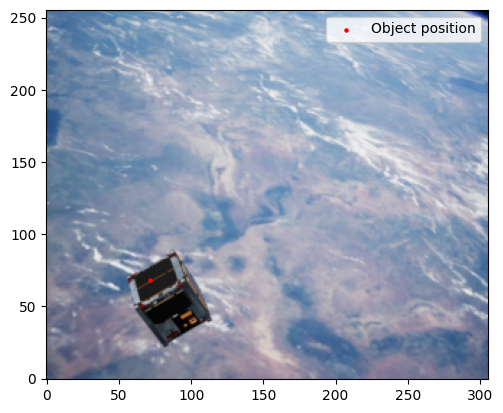

Real position: [-0.174484 -0.184005  1.116277]
Projected position: [71.766106 68.04183 ]
Reconstructed position: [-0.174484   -0.184005    1.11627698]
Reconstruction error: [3.76717471e-09 8.72096986e-09 0.00000000e+00]

Normalised figure:


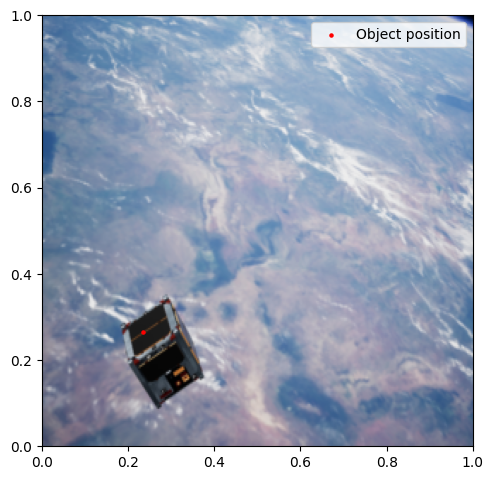

Normalised dataset position: [0.23452976 0.2657884 ]
Projected position from 3D dataset: [0.23452976 0.2657884 ]


In [59]:
# Run some tests
selected_example = training_data[3]
selected_example_pixel = position_to_pixel(selected_example[1].numpy()[:3],K)[0]
selected_example_reconstructed = pixel_to_position(selected_example_pixel, selected_example[1].numpy()[2], K)

selected_example_2D = training_data_2D[3]

print("See this example:")
plt.figure()
plt.imshow(selected_example[0].numpy().transpose(1,2,0), origin='lower')
plt.scatter([selected_example_pixel[0]],[selected_example_pixel[1]],color='r',s=5, label = 'Object position')
plt.legend()
plt.show()
plt.close()
print(f"Real position: {selected_example[1].numpy()[:3]}")
print(f"Projected position: {selected_example_pixel}")
print(f"Reconstructed position: {selected_example_reconstructed}")
print(f"Reconstruction error: {np.abs(selected_example_reconstructed-selected_example[1].numpy()[:3])}")

print("\nNormalised figure:")
plt.figure(figsize=(6.9,5.6))
plt.imshow(selected_example_2D[0].numpy().transpose(1,2,0),origin='lower',extent=(0,1,0,1))
plt.scatter([selected_example_2D[1][0]],[selected_example_2D[1][1]],color='r',s=5, label = 'Object position')
plt.legend()
plt.show()
plt.close()
print(f"Normalised dataset position: {selected_example_2D[1].numpy()[:]}")
print(f"Projected position from 3D dataset: {position_to_pixel(selected_example[1].numpy()[:3],K,norm=True)[0]}")


# Model Definition

### Full Resolution (NOT USED)

In [60]:
# THIS NETWORK IS FOR THE FULL RESOLUTION IMAGES WITHOUT DOWNSIZING THE RESOLUTION
# IT TURNS OUT TO BE TOO COMPUTATIONALLY EXPENSIVE

class CubeSat_Regression(nn.Module):
    def __init__(self, num_labels = 6, dropout_rate = 0.5):
        '''
        Initialises the network class inheriting everything from nn.Module from pytorch
            - num_labels (int): number of elements in the label for each image
            - dropout_rate (float): fraction of cells set to zero during dropout
        '''
        # Inherit the initialization from the superior class nn.Module
        super(CubeSat_Regression, self).__init__()

        # We now construct a sequence of convolutional-max pooling layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5),
            nn.MaxPool2d(kernel_size = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.Dropout2d(p=dropout_rate),
            nn.MaxPool2d(kernel_size = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
            nn.MaxPool2d(kernel_size = (3,2), stride = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,2), stride = 2),
            nn.ReLU()
        )

        # The result from the previous layers is now flattened (all the channels) and fed into a vanilla neural network:
        self.dense_layers = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features=256*31*38, out_features=num_labels),
        )

    def forward(self,x):
        '''
        Method to feedforward from input to output of the layer
        '''
        return self.dense_layers(self.conv_layers(x))

### Reduced Resolution (USED)

In [7]:

# THIS CLASS IS FOR THE NEURAL NETWORK WITH THE DOWNSIZED RESOLUTION (TO 256 PIXELS ON ITS SHORTER SIDE)

class CubeSat_Regression(nn.Module):
    def __init__(self, num_labels = 6, dropout_rate = 0.1):
        '''
        Initialises the network class inheriting everything from nn.Module from pytorch
            - num_labels (int): number of elements in the label for each image
            - dropout_rate (float): fraction of cells set to zero during dropout
        '''
        # Inherit the initialization from the superior class nn.Module
        super(CubeSat_Regression, self).__init__()

        # We now construct a sequence of convolutional-max pooling layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=8,stride=(4,2)),
            nn.Dropout2d(p=dropout_rate),
            nn.MaxPool2d(kernel_size = (3,2), stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4),
            nn.MaxPool2d(kernel_size = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,4), stride=(1,2)),
            nn.MaxPool2d(kernel_size = (2,3), stride=2),
            nn.ReLU(),
        )

        # The result from the previous layers is now flattened (all the channels) and fed into a vanilla neural network:
        self.dense_layers = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features=256*6*8, out_features=num_labels),
        )

    def forward(self,x):
        '''
        Method to feedforward from input to output of the layer
        '''
        return self.dense_layers(self.conv_layers(x))

# Training Functionalities

In [62]:

def train(model, train_loader, val_loader = False, test_loader = False, num_epochs = 40, opt = 'adam', lr = 0.1, l2_lambda = 0.1, momentum=0.5, patience = 15, register_batch = False, checkpoint_path=False):
    '''
    Function to train the model
        - model (class): Neural network object to be trained
        - train_loader (iterable): Iterable containing the training dataset (DataLoader)
        - val_loader, test_loader (iterable): Iterable containing the validation and testing datasets (DataLoader). If set to false, no validation/testing information will be extracted
        - num_epochs (int): maximum number of epochs
        - lr (float): Learning rate
        - l2_lambda (float): Weight decay 'lambda' parameter
        - momentum (float): momentum co-efficient parameter
        - patience (int): patience parameter for early stopping. Maximum number of epochs during which the validation loss has not improved in order to early stop.
    '''
    # Define the loss function, the optimizer using the input parameters, and a learning rate decay scheduler
    criterion = nn.HuberLoss(delta=1)
    scaler = GradScaler()
    if opt == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2_lambda)
    elif opt == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay = l2_lambda)
        
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4)

    # Initialize empty lists of data
    train_losses, val_losses, test_losses = [], [], []
    examples_seen, train_losses_batch = [], []

    # Initialize current time
    time_0 = time.time()

    # Counters for the early stopping
    patience_counter = 0
    best_val_loss = float('inf')

    print("################## BEGINNING TRAINING ##################\n")

    # We loop over the epochs
    #for epoch in tqdm(range(num_epochs), desc = 'Epochs'):   I REMOVED THIS LINE BUT IT CAN BE USED TO SHOW A DYNAMIC BAR OF THE PROGRESS
    for epoch in range(num_epochs):
        # We will measure the runtime
        start_time = time.time()
        
        # Model into train mode
        model.train()

        # Initialize variables for loss calculations
        running_loss = 0.

        # Iterate over the items in the loader
        for n, (inputs, labels) in enumerate(train_loader):
            # Move inputs and labels to the device (CPU or GPU)
            inputs, labels = inputs.to(device), labels.to(device)
            with autocast(device_type=device_str):
                outputs = model(inputs)                 # Feedforward the inputs to the outputs
                loss = criterion(outputs, labels)       # Calculate the loss
                
            optimizer.zero_grad()                   # Set the gradients to zero
            #loss.backward()                         # Backpropagate the error
            scaler.scale(loss).backward()
            scaler.step(optimizer)                        # Correct the parameters
            scaler.update()

            # We multiply the running loss by labels.size(0) (the batch size) because the loss function returns the average loss per sample in the batch. We calculate the actual loss and then we will average over the entire dataset
            running_loss += loss.item() * labels.size(0)

            # Now we register the evolution of the loss as a function of examples tried
            if register_batch:
                examples_seen.append(labels.size(0)*n + epoch*len(train_loader.dataset))
                train_losses_batch.append(loss.item())
                
        # We calculate the average training loss of the whole dataset
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        #################### Validation ##################################
        # If there is no validation set then we only print the training information
        if not val_loader and epoch%10==0:
            print(f"Epoch [{epoch+1} / {num_epochs}] done in {(time.time()-start_time)/60:.2f} s \n    Loss on training data: {train_loss:.3f}")
            
        # If there is we perform a validation set study as well
        elif val_loader:
            # Model into evaluation mode
            model.eval()

            # Variables for the loss calculation
            running_loss = 0.

            # Disable gradient computation
            with torch.no_grad():
                # Loop over the data in the evaluation set and perform a process analogous to the testing case, without modifying the parameters
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    with autocast(device_type=device_str):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        
                    running_loss += loss.item() * labels.size(0)

            val_loss = running_loss / len(val_loader.dataset)
            val_losses.append(val_loss)

            # Print the results for the current epoch
            print(f"Epoch [{epoch+1} / {num_epochs}] done in {(time.time()-start_time)/60:.2f} min \n    Loss on training data: {train_loss:.3f} \n    Loss on validation data: {val_loss:.3f}")

            # Now we check if the loss is improving for the early stopping case
            if best_val_loss > val_loss:
                patience_counter = 0
                best_val_loss = val_loss
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"\nEarly stop at epoch {epoch + 1}\n")
                break
            
            # Advance the scheduler (i.e. evolve the learning rate)
            scheduler.step(val_loss)

        # Get the testing set current loss
        if test_loader:
            test_loss = test(model, test_loader)
            test_losses.append([epoch,test_loss])

        if checkpoint_path and epoch%3==0:
            checkpoint = save_checkpoint(checkpoint_path, epoch, model, optimizer, scheduler, 
                                         train_losses, val_losses, test_losses, train_losses_batch=[examples_seen,train_losses_batch])

    # Do last checkpoint
    checkpoint = save_checkpoint(checkpoint_path, epoch, model, optimizer, scheduler, 
                                 train_losses, val_losses, test_losses, train_losses_batch=[examples_seen,train_losses_batch])

    if checkpoint_path:
        print(f"\nModel trained in {(time.time()-time_0)/60:.2f} min and saved at {checkpoint_path}")
    else:
        print(f"\nModel trained in {(time.time()-time_0)/60:.2f} min")

    return checkpoint

def test(model, test_loader):
    '''
    Function to calculate the loss of passing the testing data through the model
        - model (class): Neural network object to be trained
        - test_loader (iterable): Iterable containing the training dataset (DataLoader)
    '''
    # The process is analogous to the testing and validation cases above
    criterion = nn.HuberLoss(delta=1)
    
    model.eval()
    running_loss = 0.
    
    for inputs, labels in test_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        with autocast(device_type=device_str):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * labels.size(0)

    return  running_loss / len(test_loader.dataset)

def save_checkpoint(savepath, epoch, model, optimizer, scheduler, train_losses=[], val_losses=[], test_losses=[], train_losses_batch=[]):
    '''
    Function to save the progress of the model training to a file
        - savepath (str): Path to file
        - epoch (int): Current epoch of the checkpoint
        - model (class): Pytorch model under training
        - optimizer (class): Pytorch optimizer used
        - scheduler (class): Pytorch class used
        - train_losses (1D list): List of training data loss at each epoch
        - val_losses (1D list): List of validation data loss at each epoch
        - test_losses (1D list): List of testing data loss at each epoch
        - train_losses_batch (2D list): List of training data loss as a function of the number of examples seen by the model

        '''
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }
    if train_losses:
        checkpoint['train_losses'] = train_losses
    if val_losses:
        checkpoint['val_losses'] = val_losses
    if test_losses:
        checkpoint['test_losses'] = test_losses
    if train_losses_batch:
        checkpoint['train_losses_batch'] = train_losses_batch

    torch.save(checkpoint, savepath)
    print(f"Checkpoint saved successfully")

    return checkpoint

# Definition of Final Datasets (With Validation Split) and Model

In [63]:
# Having checked everything is correct we initialize the data as a tensor

# Define validation split fraction and random seed for reproducibility
validation_split = (0.166,43)

# Define dataset objects
training_data = CubeSat_Dataset(image_dir=training_images, label_file=training_labels, validation_split = validation_split, mode = 'train', transform=transform, num_labels = 2)
validation_data = CubeSat_Dataset(image_dir=training_images, label_file=training_labels, validation_split = validation_split, mode = 'val', transform=transform, num_labels = 2)
testing_data = CubeSat_Dataset(image_dir=testing_images, label_file=testing_labels,transform=transform, num_labels = 2)

print(f"\nWe have {len(training_data)} training images, {len(validation_data)} validation images, and {len(testing_data)} testing images")

# We batch the datasets and produce the data loader iterables
dataloader_training = DataLoader(training_data, batch_size = 32, shuffle = True, num_workers = 2, pin_memory = True)
dataloader_val = DataLoader(validation_data, batch_size = 32, shuffle = False)
dataloader_testing = DataLoader(testing_data, batch_size = 32, shuffle = False)

Creating dataset with 2D normalised pixel positions
Creating dataset with 2D normalised pixel positions
Creating dataset with 2D normalised pixel positions

We have 6670 training images, 1328 validation images, and 2000 testing images


In [64]:
# Define the model and the device
model = CubeSat_Regression(num_labels = 2, dropout_rate = 0.1)
from pympler import asizeof

print(f'Size of model: {asizeof.asizeof(model)/(1024**2):.2f} MB')
print(f'Size of training (2D) dataloader: {asizeof.asizeof(dataloader_training)/(1024**2):.2f} MB')
print(f'Size of validation (2D) dataloader: {asizeof.asizeof(dataloader_val)/(1024**2):.2f} MB')
print(f'Size of testing (2D) dataloader: {asizeof.asizeof(dataloader_testing)/(1024**2):.2f} MB')

Size of model: 0.04 MB
Size of training (2D) dataloader: 0.98 MB
Size of validation (2D) dataloader: 0.20 MB
Size of testing (2D) dataloader: 0.31 MB


# Training of (x,y) Regressor

In [65]:
model = CubeSat_Regression(num_labels = 2, dropout_rate = 0.1).to(device)

# We train the model!
checkpoint = train(
    model, dataloader_training, dataloader_val, dataloader_testing,
    num_epochs = 50, opt = 'adam', lr = 0.001, l2_lambda = 1e-4, momentum=None, patience = 6,
    register_batch=True, checkpoint_path = "/kaggle/working/checkpoint.pth"
)
#checkpoint = train(
#    model, dataloader_training, dataloader_val, dataloader_testing,
#    num_epochs = 5, lr = 0.1, l2_lambda = 0.3, momentum=0.3, patience = 30,
#    register_batch=True
#)

################## BEGINNING TRAINING ##################

Epoch [1 / 50] done in 5.90 min 
    Loss on training data: 0.012 
    Loss on validation data: 0.005
Checkpoint saved successfully
Epoch [2 / 50] done in 3.75 min 
    Loss on training data: 0.004 
    Loss on validation data: 0.003
Epoch [3 / 50] done in 3.76 min 
    Loss on training data: 0.003 
    Loss on validation data: 0.002
Epoch [4 / 50] done in 3.73 min 
    Loss on training data: 0.002 
    Loss on validation data: 0.002
Checkpoint saved successfully
Epoch [5 / 50] done in 3.81 min 
    Loss on training data: 0.002 
    Loss on validation data: 0.002
Epoch [6 / 50] done in 3.76 min 
    Loss on training data: 0.002 
    Loss on validation data: 0.002
Epoch [7 / 50] done in 3.70 min 
    Loss on training data: 0.002 
    Loss on validation data: 0.002
Checkpoint saved successfully
Epoch [8 / 50] done in 3.69 min 
    Loss on training data: 0.002 
    Loss on validation data: 0.002
Epoch [9 / 50] done in 3.70 min 
   

# Training of z Regressor

In [66]:
# NOW WE TRAIN A SECOND MODEL FOR THE Z POSITION
# Define dataset objects
training_data = CubeSat_Dataset(image_dir=training_images, label_file=training_labels, validation_split = validation_split, mode = 'train', transform=transform, num_labels = 'z')
validation_data = CubeSat_Dataset(image_dir=training_images, label_file=training_labels, validation_split = validation_split, mode = 'val', transform=transform, num_labels = 'z')
testing_data = CubeSat_Dataset(image_dir=testing_images, label_file=testing_labels,transform=transform, num_labels = 'z')

print(f"\nWe have {len(training_data)} training images, {len(validation_data)} validation images, and {len(testing_data)} testing images")

# We batch the datasets and produce the data loader iterables
dataloader_training = DataLoader(training_data, batch_size = 32, shuffle = True)
dataloader_val = DataLoader(validation_data, batch_size = 32, shuffle = False)
dataloader_testing = DataLoader(testing_data, batch_size = 32, shuffle = False)

# We define the model
model_z = CubeSat_Regression(num_labels = 1, dropout_rate = 0.1).to(device)

# We train the model!
checkpoint_z = train(
    model_z, dataloader_training, dataloader_val, dataloader_testing,
    num_epochs = 50, opt = 'adam', lr = 0.001, l2_lambda = 1e-4, momentum=None, patience = 6,
    register_batch=True, checkpoint_path = "/kaggle/working/checkpoint_z.pth"
)
#checkpoint_z = train(
#    model_z, dataloader_training, dataloader_val, dataloader_testing,
#    num_epochs = 4, lr = 0.1, l2_lambda = 0.3, momentum=0.3, patience = 30,
#    register_batch=True
#)


We have 6670 training images, 1328 validation images, and 2000 testing images
################## BEGINNING TRAINING ##################

Epoch [1 / 50] done in 5.87 min 
    Loss on training data: 0.097 
    Loss on validation data: 0.064
Checkpoint saved successfully
Epoch [2 / 50] done in 5.92 min 
    Loss on training data: 0.056 
    Loss on validation data: 0.049
Epoch [3 / 50] done in 5.94 min 
    Loss on training data: 0.035 
    Loss on validation data: 0.034
Epoch [4 / 50] done in 6.02 min 
    Loss on training data: 0.028 
    Loss on validation data: 0.027
Checkpoint saved successfully
Epoch [5 / 50] done in 6.10 min 
    Loss on training data: 0.025 
    Loss on validation data: 0.030
Epoch [6 / 50] done in 6.07 min 
    Loss on training data: 0.036 
    Loss on validation data: 0.026
Epoch [7 / 50] done in 5.90 min 
    Loss on training data: 0.023 
    Loss on validation data: 0.024
Checkpoint saved successfully
Epoch [8 / 50] done in 5.88 min 
    Loss on training data:

# Re-Loading Results

In [8]:
# Load data (useful if the session is lost
checkpoint = torch.load("/kaggle/input/cubesat-checkpoints/checkpoint.pth", map_location=torch.device('cpu'), weights_only=True)
checkpoint_z = torch.load("/kaggle/input/cubesat-checkpoints/checkpoint_z.pth", map_location=torch.device('cpu'), weights_only=True)

model = CubeSat_Regression(num_labels = 2, dropout_rate = 0.1)
model.load_state_dict(checkpoint['model_state_dict'])

model_z = CubeSat_Regression(num_labels = 1, dropout_rate = 0.1)
model_z.load_state_dict(checkpoint_z['model_state_dict'])

<All keys matched successfully>

In [9]:
# We define the datasets only with 3 labels: x, y and z
testing_data = CubeSat_Dataset(image_dir=testing_images, label_file=testing_labels,transform=transform, num_labels = 3)

Creating dataset with 3D labels directly from csv file


# Results: Predictions on Random Images and Error

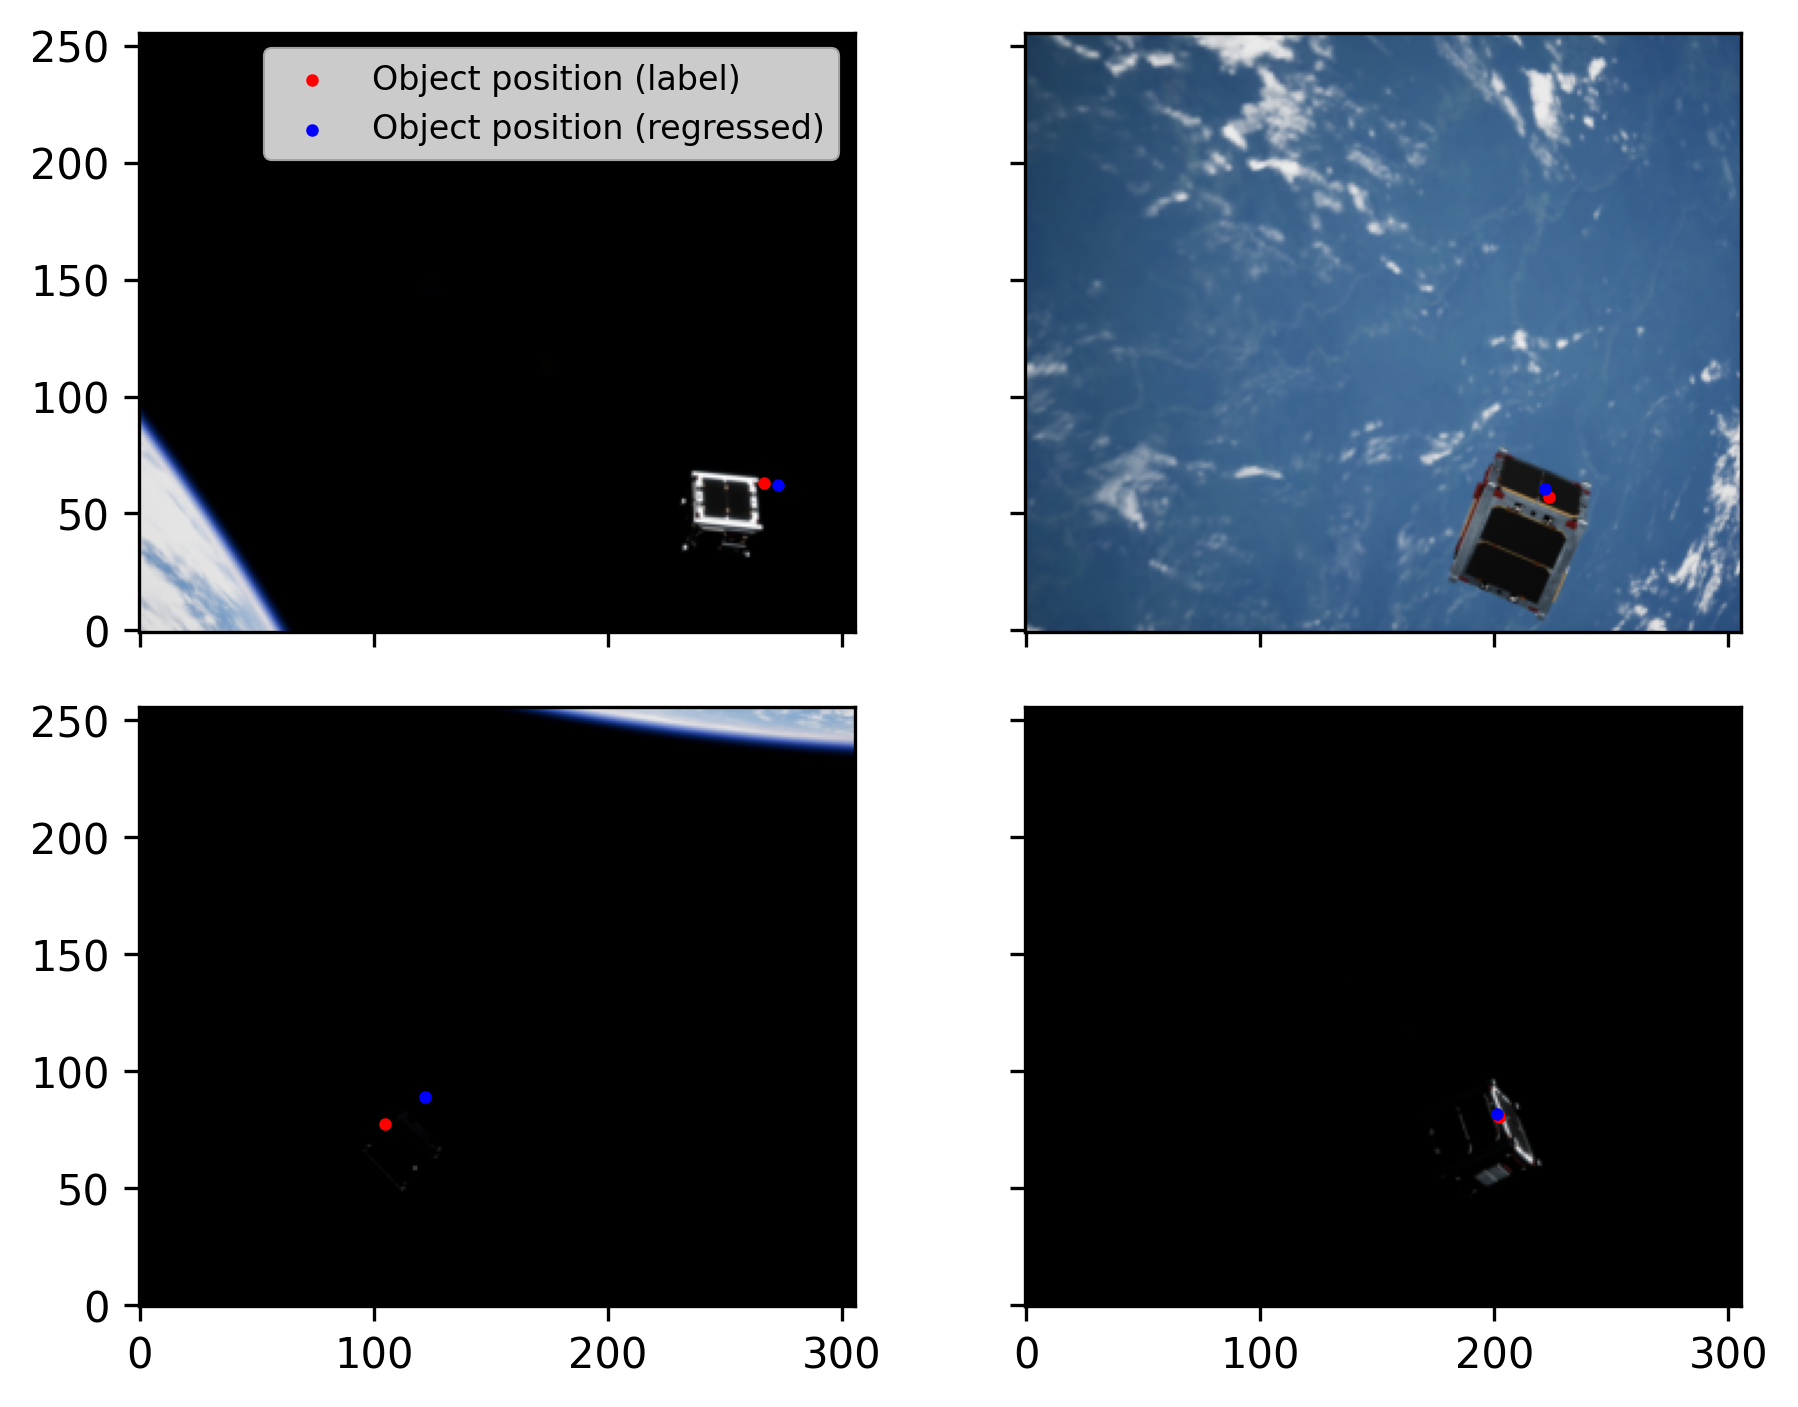

For one example:

Real position (pixel): [202.13965  80.25606]
Network position(pixel): [201.16245210170746, 81.44659423828125]
Error(pixel): [0.97719634 1.1905365 ]
Fractional error(pixel %): [0.48342636 1.4834226 ]

Real position (pos): [ 0.125039 -0.173578  1.322413]
Network position (pos): [ 0.13658723 -0.18863223  1.4738563 ]
Error (pos): [0.01154824 0.01505424 0.15144336]
Fractional error(pixel %): [ 9.235707 -8.672896 11.452048]


In [20]:
import random
random_indices = [random.randint(0, len(testing_data)) for _ in range(4)]
#random_indices = [i for i in range(4)]

fig, axs = plt.subplots(2,2,dpi=300,sharex=True, sharey=True)

model.to(device)
model.eval()
model_z.eval()
with torch.no_grad():
    for i, (r_idx, ax) in enumerate(zip(random_indices, axs.flat)):
    
        # We perform some tests!
        selected_example = testing_data[r_idx]
        image_example_tensor = selected_example[0].unsqueeze(0).to(device)
        #with autocast(device_type=device_str):
        output_example_norm = model(image_example_tensor.to(device)).cpu().numpy()[0]
        output_example_z = model_z(image_example_tensor.to(device)).cpu().numpy()[0]
        
        selected_example_pixel = position_to_pixel(selected_example[1].numpy(),K)[0]
        output_example_pixel = [output_example_norm[0]*2448/8, output_example_norm[1]*2048/8]
        
        ax.imshow(selected_example[0].numpy().transpose(1,2,0), origin='lower')
        ax.scatter([selected_example_pixel[0]],[selected_example_pixel[1]],color='r',s=4, label = 'Object position (label)' if i==0 else _)
        ax.scatter([output_example_pixel[0]],[output_example_pixel[1]],color='b',s=4, label = 'Object position (regressed)' if i==0 else _)
        
axs[0][0].legend(fontsize=8)
plt.tight_layout()
plt.show()
plt.close()

print("For one example:")
print(f"\nReal position (pixel): {selected_example_pixel}")
print(f"Network position(pixel): {output_example_pixel}")
error = abs(selected_example_pixel-output_example_pixel)
print(f"Error(pixel): {error}")
print(f"Fractional error(pixel %): {100*error/selected_example_pixel}")

print(f"\nReal position (pos): {selected_example[1].numpy()}")
print(f"Network position (pos): {pixel_to_position(output_example_pixel, output_example_z, K)[:,0]}")
error = abs(selected_example[1].numpy() - pixel_to_position(output_example_pixel, output_example_z, K)[:,0])
print(f"Error (pos): {error}")
print(f"Fractional error(pixel %): {100*error/selected_example[1].numpy()}")

# Results: Loss Evolution with Epoch and Examples Seen

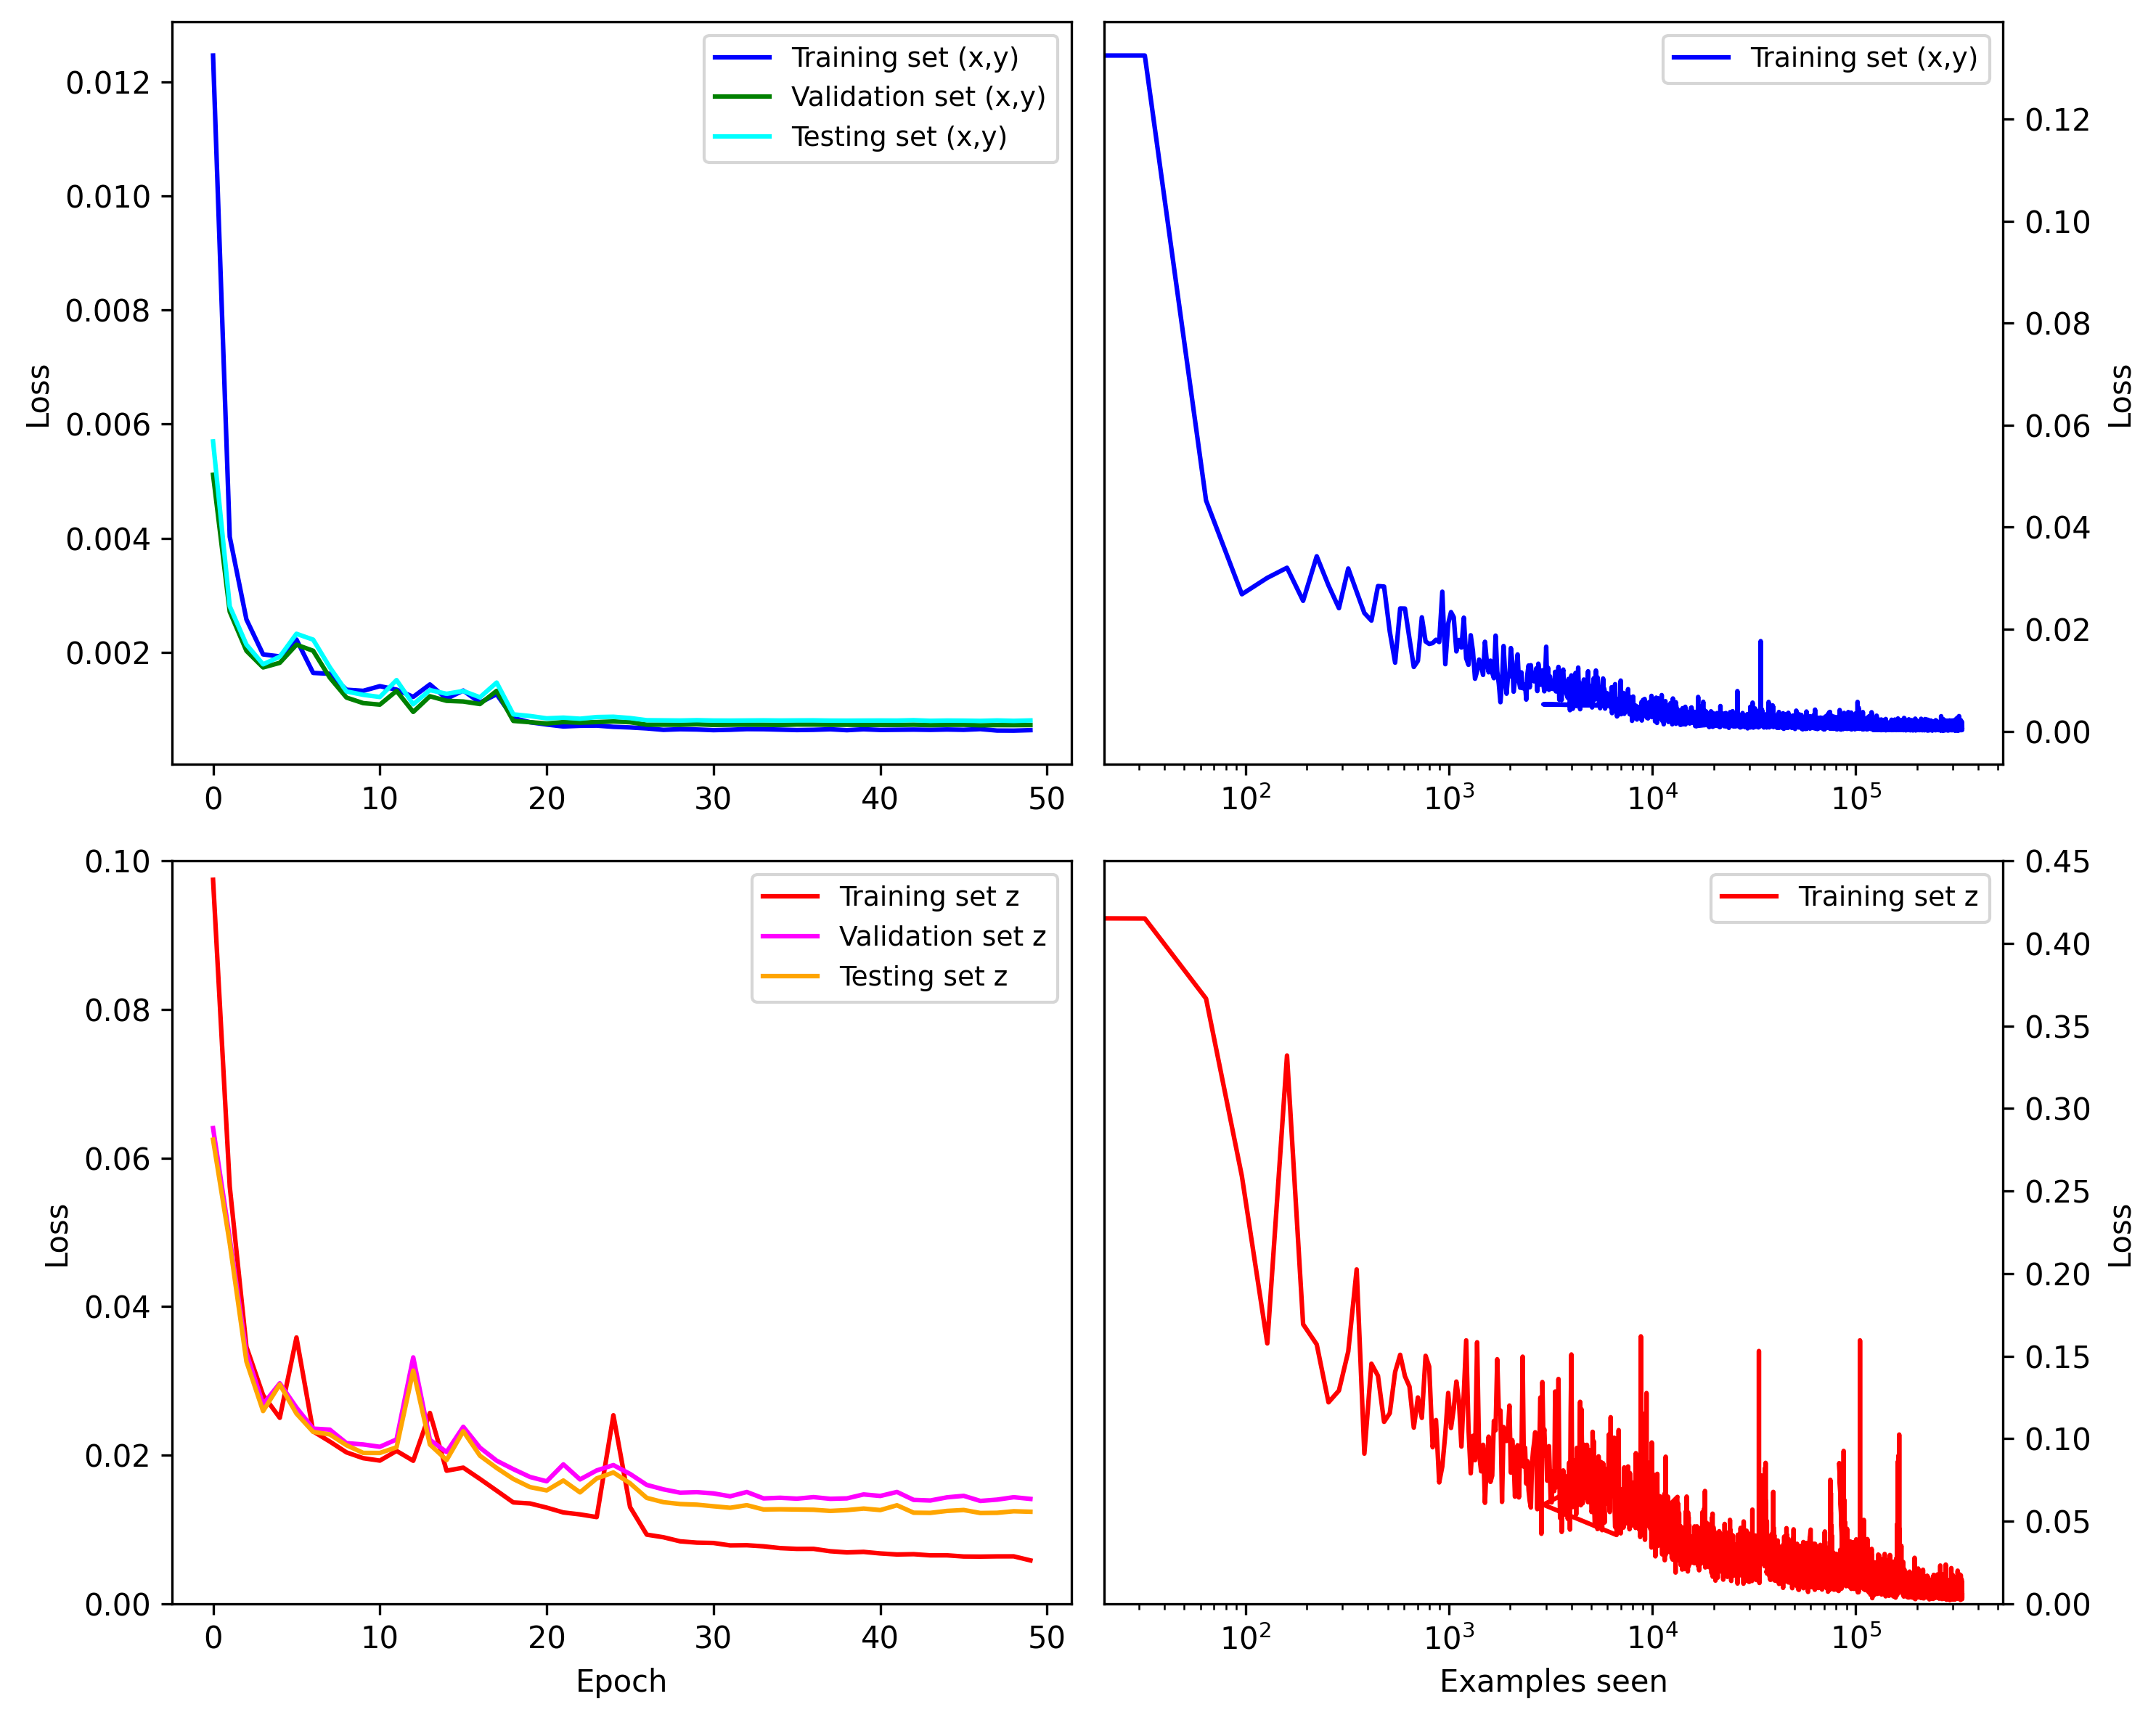

In [48]:

fig,axs = plt.subplots(2,2,dpi=300, figsize = (10,8))

axs[1][0].set_ylim([0,0.1])
axs[1][1].set_ylim([0,0.45])

for ax in axs[:,1]:
    ax.yaxis.set_label_position('right')
    ax.yaxis.tick_right()
    ax.set_ylabel('Loss')

for ax in axs[:,0]:
    ax.set_ylabel('Loss')

for ax in axs[:,1]:
    ax.set_xscale('log')

axs[1][0].set_xlabel('Epoch')
axs[1][1].set_xlabel('Examples seen')

# Loss against epoch
axs[0][0].plot(checkpoint['train_losses'], 'b', label='Training set (x,y)')
axs[0][0].plot(checkpoint['val_losses'], 'g', label='Validation set (x,y)')
axs[0][0].plot(np.array(checkpoint['test_losses'])[:,1], 'cyan', label='Testing set (x,y)')

axs[1][0].plot(checkpoint_z['train_losses'], 'r', label='Training set z')
axs[1][0].plot(checkpoint_z['val_losses'], 'magenta', label='Validation set z')
axs[1][0].plot(np.array(checkpoint_z['test_losses'])[:,1], 'orange', label='Testing set z')

# Test loss against examples seen
axs[0][1].plot(checkpoint['train_losses_batch'][0], checkpoint['train_losses_batch'][1], 'b', label='Training set (x,y)')
axs[1][1].plot(checkpoint_z['train_losses_batch'][0], checkpoint_z['train_losses_batch'][1], 'r', label='Training set z')

for ax in axs.flat:
    ax.legend(fontsize=9)

plt.tight_layout()
plt.show()
plt.close()